In [1]:
import copy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
torch.cuda.is_available()

False

In [3]:
X = pd.read_csv('./data/preprocessing/X_fill.csv')
y = pd.read_csv('./data/preprocessing/y.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [5]:
# top_feature_choice = [
#     "wrkstat_Working fulltime",
#     "polviews_Conservative",
#     "educ_center",
#     "polviews_Slightly liberal",
#     "polviews_Moderate",
#     "polviews_unknown"
# ]

# X_train = X_train[X_train.columns.intersection(top_feature_choice)]
# X_test = X_test[X_test.columns.intersection(top_feature_choice)]

In [6]:
X_train.info()
print(X_train.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 584 to 1126
Data columns (total 34 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   educ_center                                                      1319 non-null   float64
 1   harass5_Does not apply (i do not have a job/superior/co-worker)  1319 non-null   int64  
 2   harass5_No                                                       1319 non-null   int64  
 3   harass5_Yes                                                      1319 non-null   int64  
 4   harass5_unknown                                                  1319 non-null   int64  
 5   polviews_Conservative                                            1319 non-null   int64  
 6   polviews_Extremely liberal                                       1319 non-null   int64  
 7   polviews_Extrmly conservative                

In [7]:
model = nn.Sequential(
  nn.Linear(34, 64),
  nn.ReLU(),
  nn.Sigmoid(),
  nn.Linear(64, 1)
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train['email_time_center'].to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test['email_time_center'].to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [9]:
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [10]:

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
early_stopping_epoches = 10

In [11]:
# training loop
early = 0
for epoch in range(n_epochs):
    print(f'process epoch: {epoch}')
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    print(f'complete epoch {epoch} with mse {mse}')
    if mse > best_mse:
        early += 1
        if early > early_stopping_epoches:
            print(f'early stopping')
            break
    
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

process epoch: 0
complete epoch 0 with mse 0.014355035498738289
process epoch: 1


complete epoch 1 with mse 0.014243549667298794
process epoch: 2
complete epoch 2 with mse 0.014143603853881359
process epoch: 3
complete epoch 3 with mse 0.014055009000003338
process epoch: 4
complete epoch 4 with mse 0.013977435417473316
process epoch: 5
complete epoch 5 with mse 0.01391196995973587
process epoch: 6
complete epoch 6 with mse 0.013856269419193268
process epoch: 7
complete epoch 7 with mse 0.01380995288491249
process epoch: 8
complete epoch 8 with mse 0.013769944198429585
process epoch: 9
complete epoch 9 with mse 0.013736061751842499
process epoch: 10
complete epoch 10 with mse 0.013706301338970661
process epoch: 11
complete epoch 11 with mse 0.013678665272891521
process epoch: 12
complete epoch 12 with mse 0.013655783608555794
process epoch: 13
complete epoch 13 with mse 0.013634485192596912
process epoch: 14
complete epoch 14 with mse 0.013615278527140617
process epoch: 15
complete epoch 15 with mse 0.013597137294709682
process epoch: 16
complete epoch 16 with mse 0.

MSE: 0.013379
RMSE: 0.115668


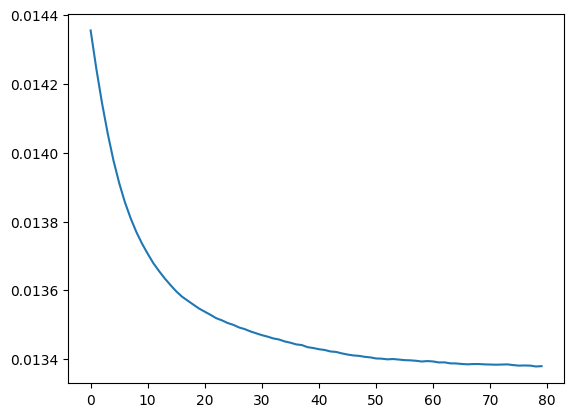

In [12]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.6f" % best_mse)
print("RMSE: %.6f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [13]:
y_pred = model(X_test)

In [14]:
type(y_pred)

torch.Tensor

In [15]:
y_pred_df = pd.DataFrame(y_pred.detach().numpy())
y_test_df = pd.DataFrame(y_test.detach().numpy())

In [16]:
mse = mean_squared_error(y_test_df, y_pred_df)
r2 = r2_score(y_test_df, y_pred_df)

print(f'MSE: {mse}')
print(f'RMSE: {np.sqrt(mse)}')
print(f'R2: {r2}')

MSE: 0.013378978706896305
RMSE: 0.11566753685474396
R2: 0.06943622035726826


In [17]:
from torcheval.metrics import R2Score

metric = R2Score()

metric.update(y_test, y_pred)
r2 = metric.compute()
print(r2)

tensor(-11.1955)


array([[<Axes: title={'center': '0'}>]], dtype=object)

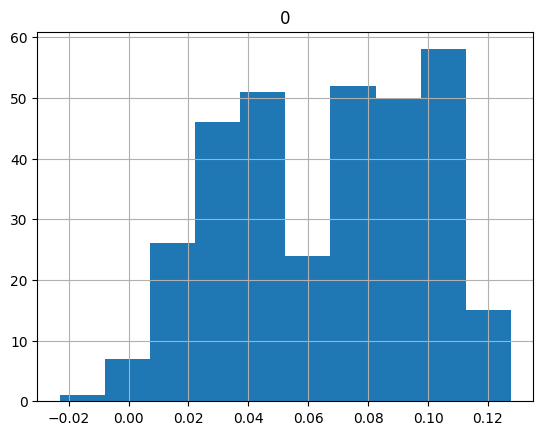

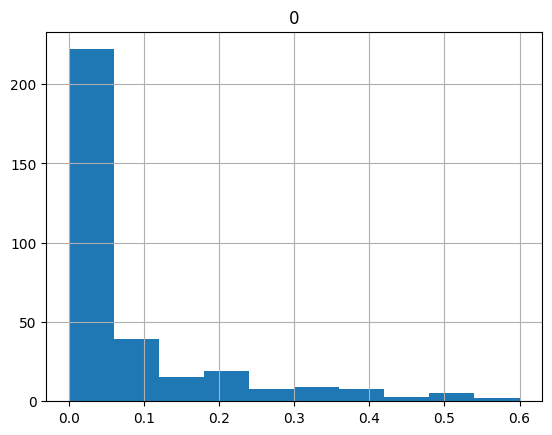

In [18]:
y_pred_df.hist()
y_test_df.hist()